In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,  cross_validate
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score,roc_curve, roc_auc_score

from utils.plot import plot_boxplots_by_columns, plot_by_columns, plot_boxplots_by_columns_hue, plot_bar_list_features
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_name = "diabetes_prediction_dataset.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "iammustafatz/diabetes-prediction-dataset",
    file_name,
)

df.head()

/Users/evertonvanonifernandes/.pyenv/versions/3.11.6/envs/diabetes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/4c/wg61_x3x2r99nvc559db4jk40000gn/T/ipykernel_59066/3025773727.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


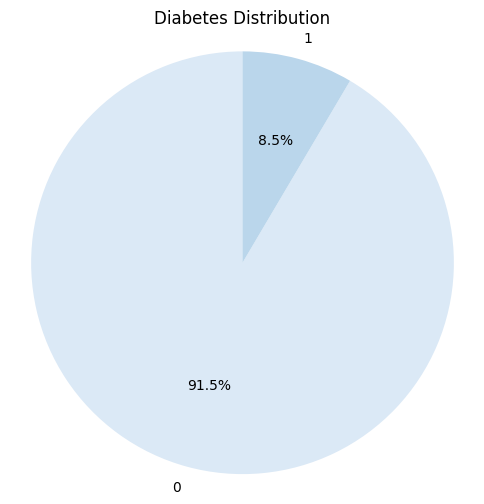

In [4]:
column ='diabetes'
column_name='gender'
df_counts = df.groupby(f'{column}').count()[column_name].sort_values(ascending=False).reset_index(name='count')[0:10]
df_counts[f'{column}'] = df_counts[f'{column}'].astype(str)

plt.figure(figsize=(6, 6))
plt.pie(df_counts['count'], labels=df_counts['diabetes'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Blues'))
plt.title('Diabetes Distribution')
plt.axis('equal')
plt.show()

In [5]:
df['blood_glucose_level'] = df['blood_glucose_level'].astype(float)


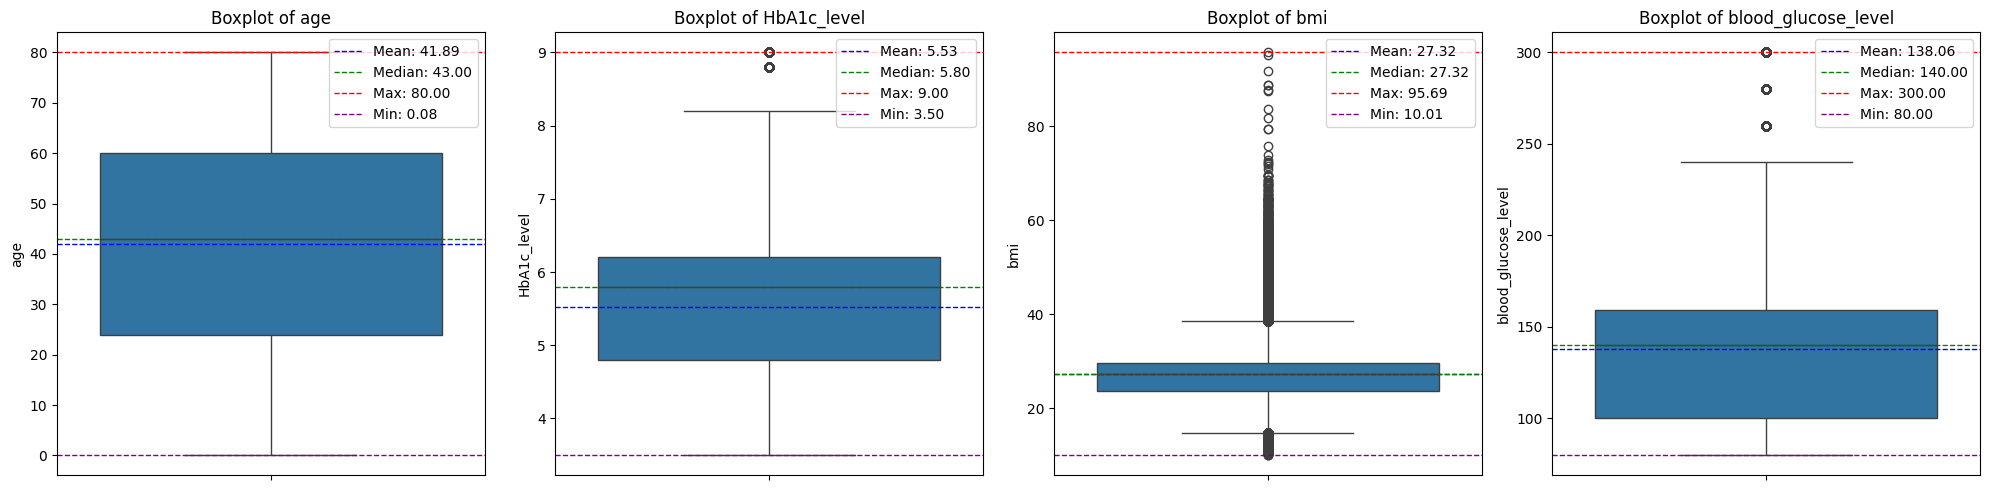

In [6]:

features_list = df.select_dtypes("float").columns.tolist()
plot_boxplots_by_columns(df,features_list)


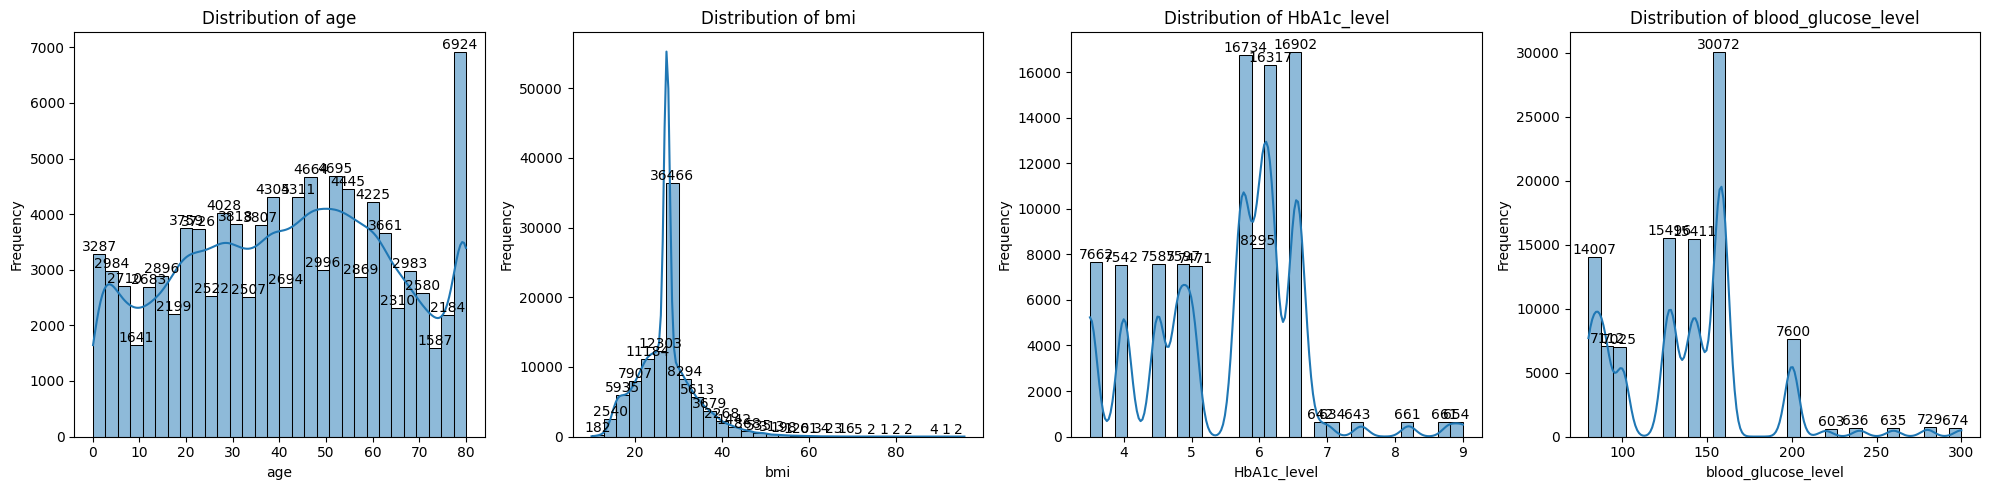

In [7]:
plot_by_columns(df,features_list)


In [8]:
string_features =  df.select_dtypes("object").columns.tolist()
string_features_bool = df.select_dtypes("int").columns.tolist()
string_features_bool.remove('diabetes')

/Users/evertonvanonifernandes/Documents/Personal/diabetes-neural-network/notebooks/utils/plot.py:279: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df_counts[f'{column}'], rotation=45, ha='right')
/Users/evertonvanonifernandes/Documents/Personal/diabetes-neural-network/notebooks/utils/plot.py:279: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df_counts[f'{column}'], rotation=45, ha='right')


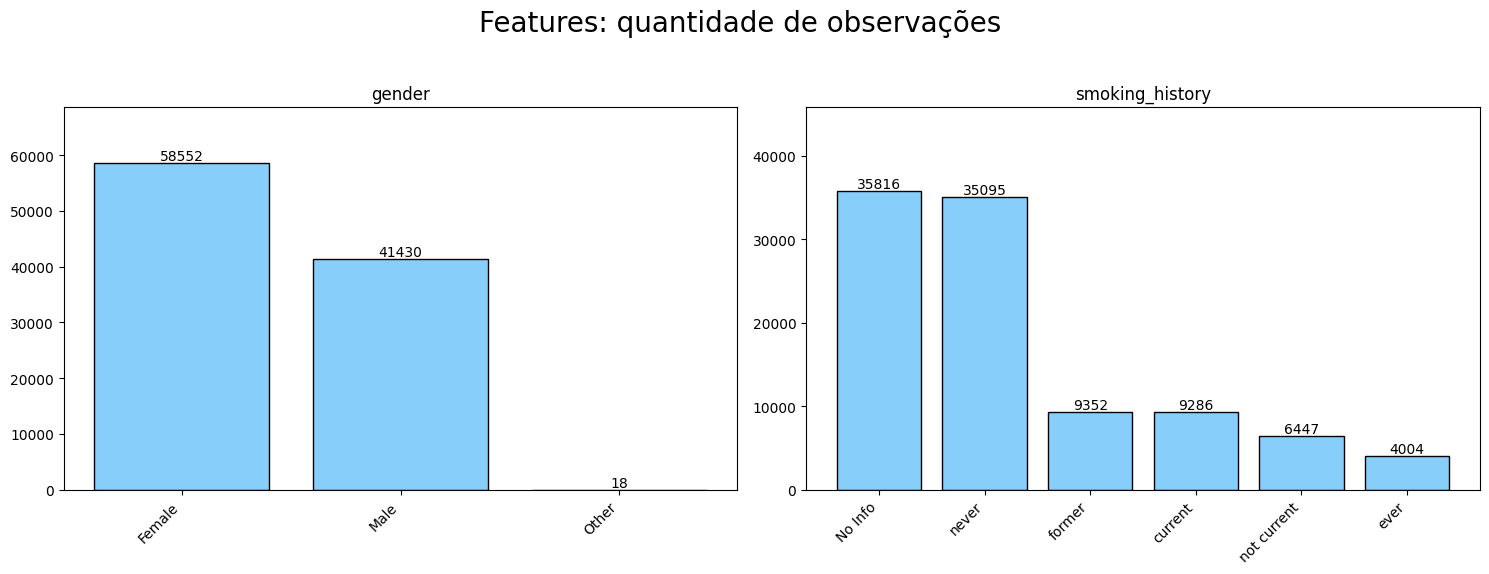

In [9]:
plot_bar_list_features(df=df, feature_list = string_features)


/Users/evertonvanonifernandes/Documents/Personal/diabetes-neural-network/notebooks/utils/plot.py:279: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df_counts[f'{column}'], rotation=45, ha='right')
/Users/evertonvanonifernandes/Documents/Personal/diabetes-neural-network/notebooks/utils/plot.py:279: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df_counts[f'{column}'], rotation=45, ha='right')


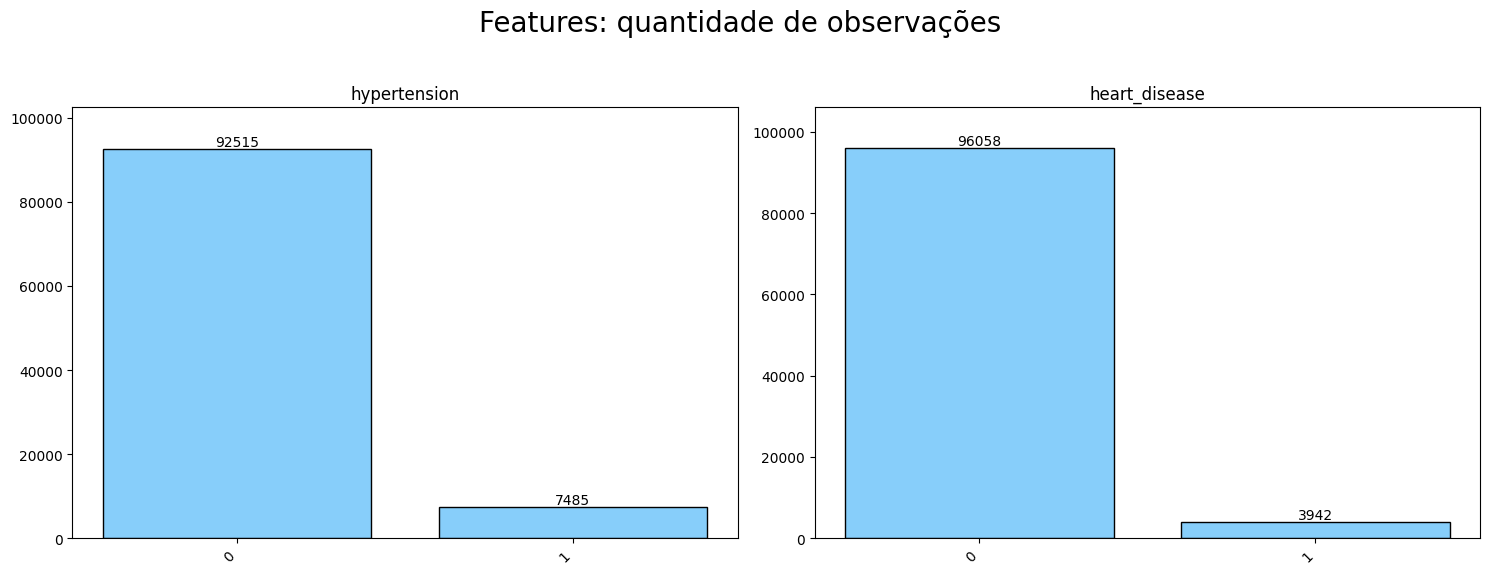

In [10]:
plot_bar_list_features(df=df, feature_list = string_features_bool)


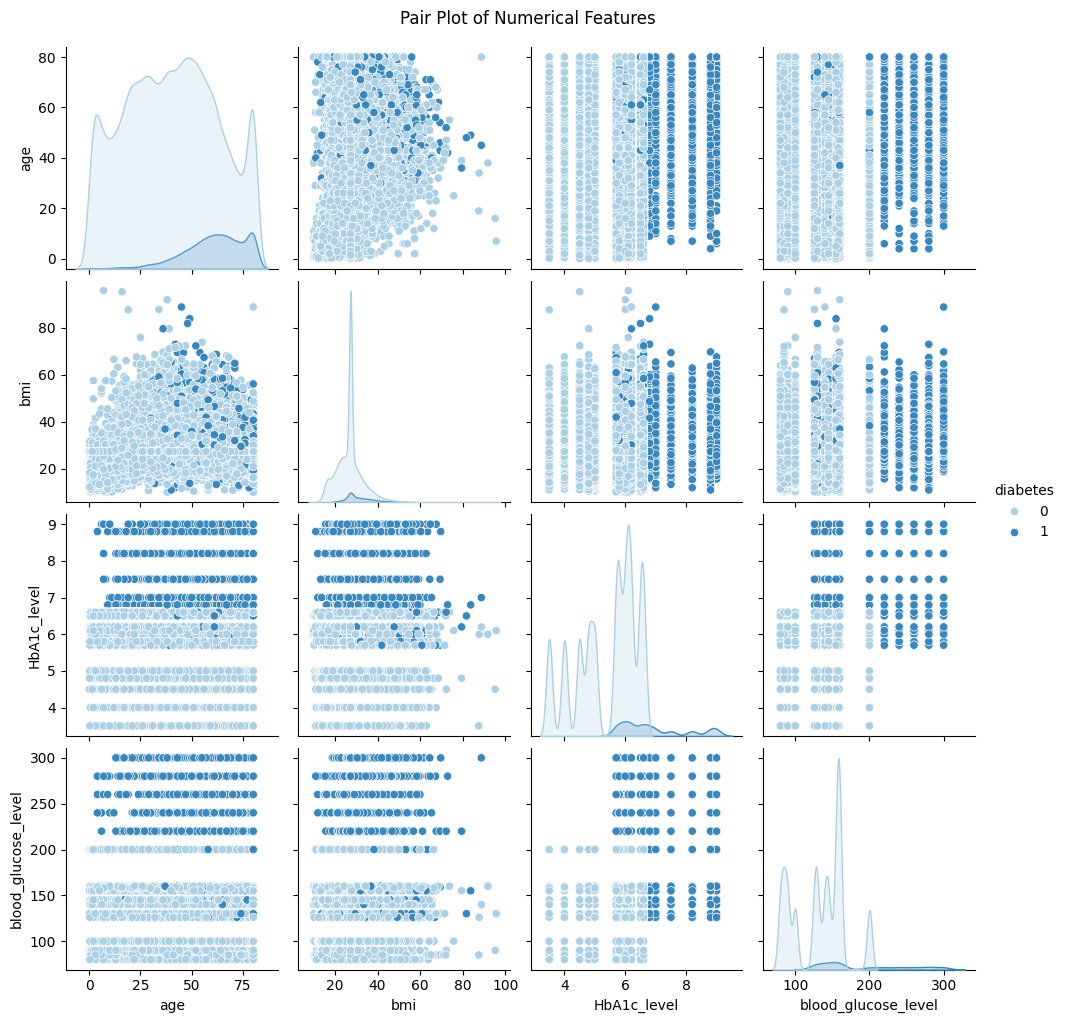

In [11]:

sns.pairplot(df[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']], hue='diabetes', palette='Blues')
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

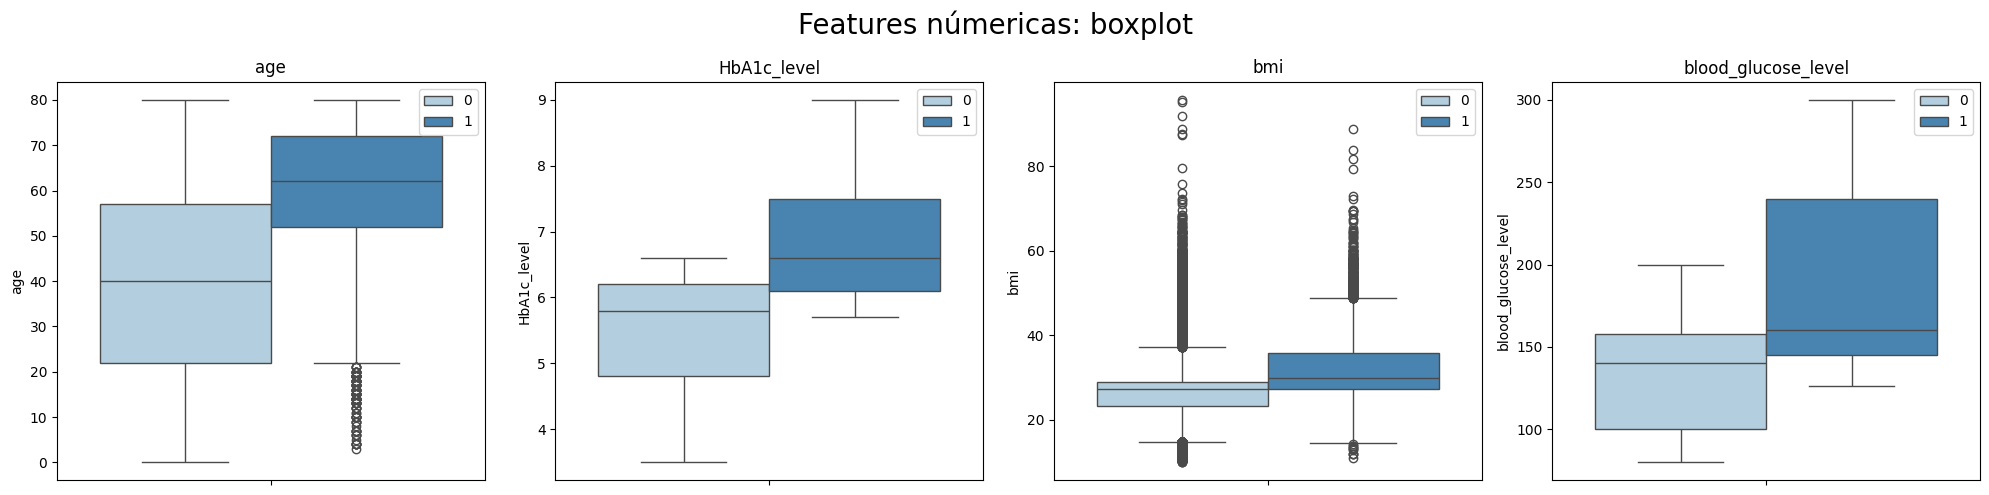

In [12]:

plot_boxplots_by_columns_hue(
    df=df,
    column_names=['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'],
    hue='diabetes')

In [13]:
correlation_matrix = df[['age',  'bmi', 'HbA1c_level', 'blood_glucose_level','diabetes']].corr(method='pearson')


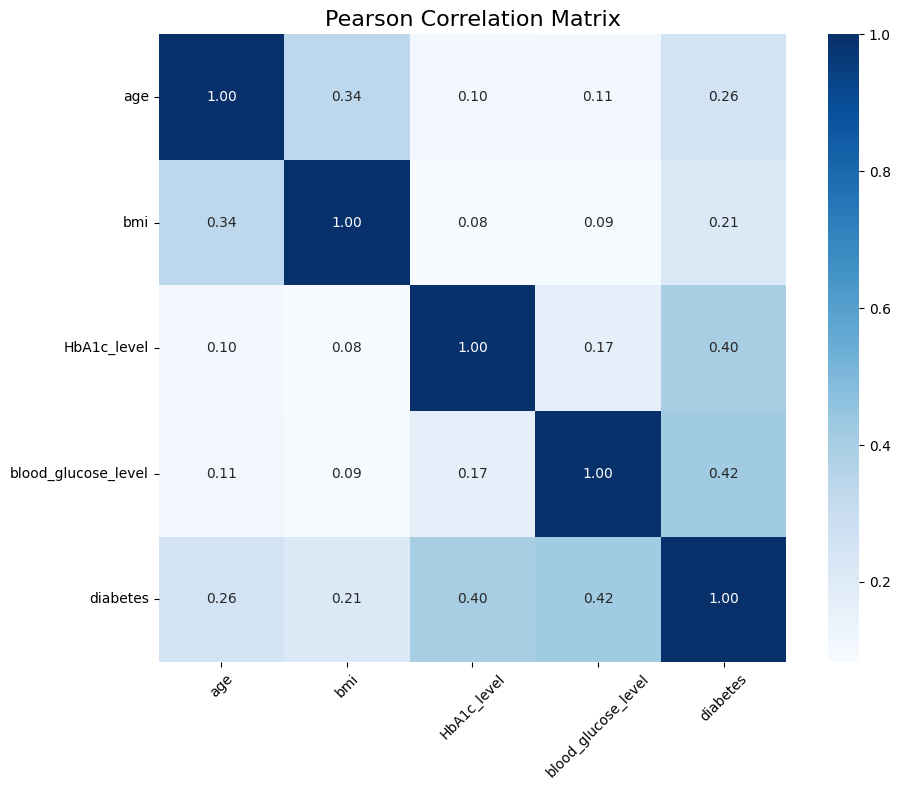

In [14]:

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True, square=True)
plt.title("Pearson Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [15]:
string_features_bool


['hypertension', 'heart_disease']

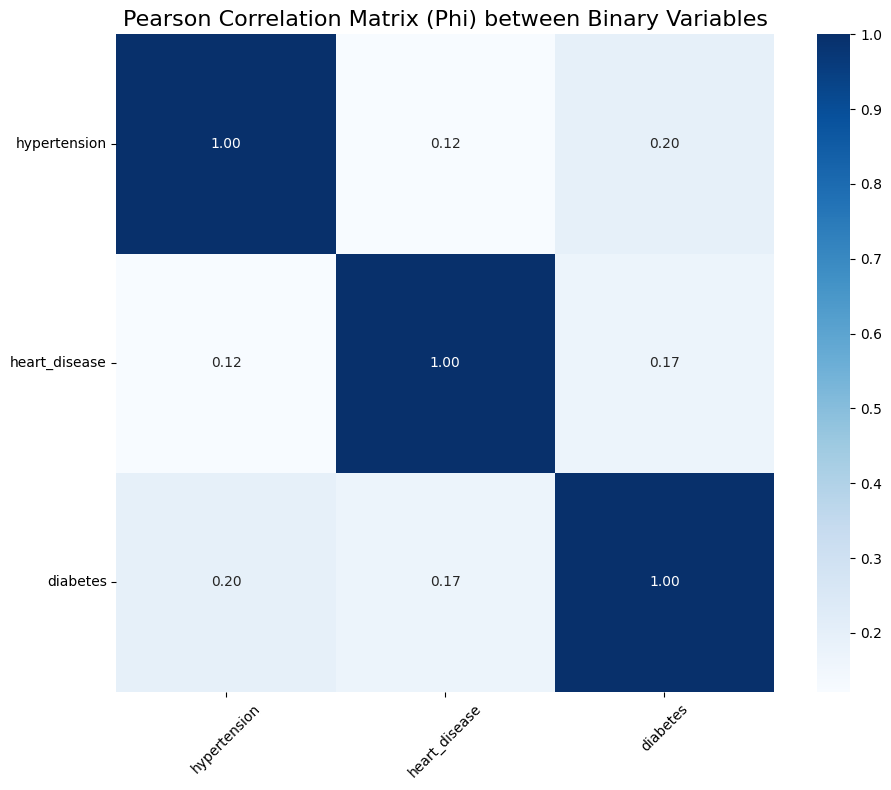

In [16]:

correlation_matrix_binary = df[['hypertension', 'heart_disease','diabetes']].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_binary, annot=True, fmt=".2f", cmap="Blues", cbar=True, square=True)
plt.title("Pearson Correlation Matrix (Phi) between Binary Variables", fontsize=16)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Target variable distribution (count):
                  count
diabetes               
Non-diabetic (0)  91500
Diabetic (1)       8500

Target variable distribution (%):
diabetes
Non-diabetic (0)    91.5%
Diabetic (1)         8.5%
Name: count, dtype: object


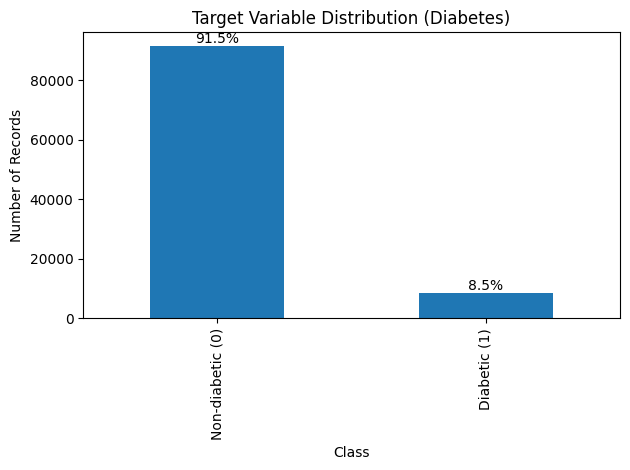

In [17]:
def to_label(v):
    s = str(v).strip().lower()
    if s in {"1", "true", "yes", "y", "positivo", "positive"}:
        return "Diabetic (1)"
    if s in {"0", "false", "no", "n", "negativo", "negative"}:
        return "Non-diabetic (0)"
    try:
        return "Diabetic (1)" if float(s) == 1.0 else "Non-diabetic (0)"
    except:
        return s

TARGET_COL = "diabetes"
y = df[TARGET_COL].map(to_label)

counts = y.value_counts()
perc = (counts / counts.sum() * 100).round(1)

print("Target variable distribution (count):")
print(counts.to_frame("count"))
print("\nTarget variable distribution (%):")
print(perc.astype(str) + "%")

ax = counts.plot(kind="bar")
ax.set_title("Target Variable Distribution (Diabetes)")
ax.set_xlabel("Class")
ax.set_ylabel("Number of Records")

for p, v in enumerate(counts.values):
    ax.text(p, v, f"{perc.iloc[p]}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [18]:
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

print("Numerical features:", num_cols)

Numerical features: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']


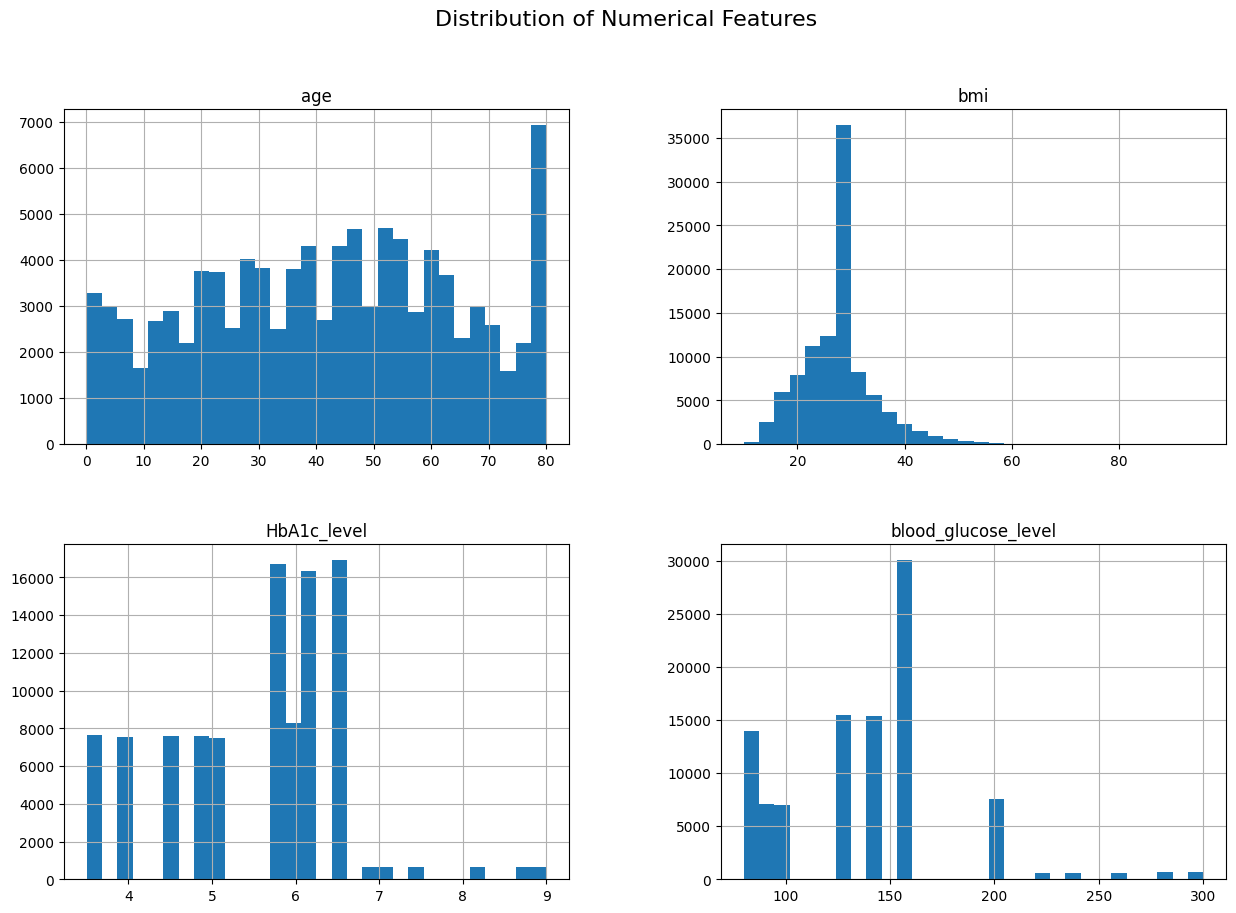

In [19]:
df[num_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

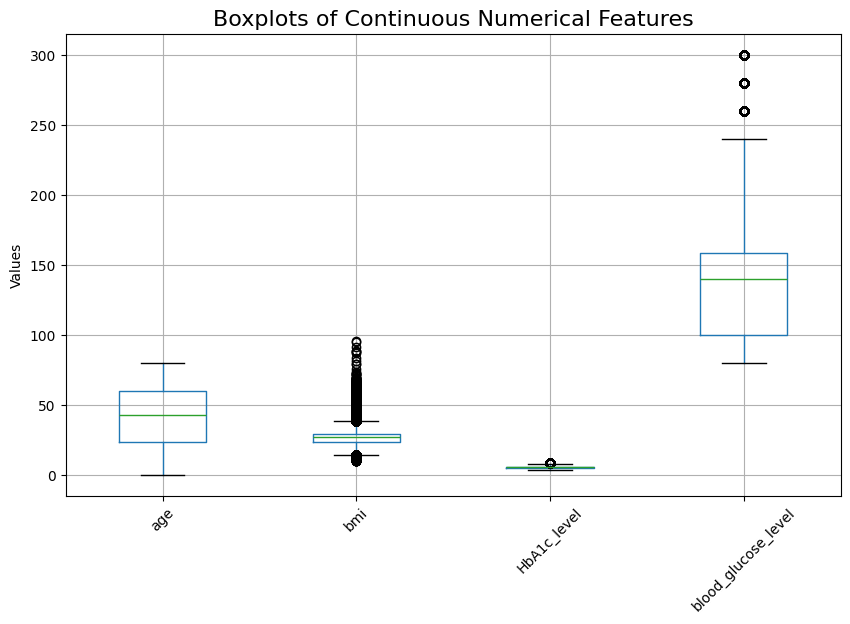

In [20]:
cont_cols = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

plt.figure(figsize=(10, 6))
df[cont_cols].boxplot()
plt.title("Boxplots of Continuous Numerical Features", fontsize=16)
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.show()